In [122]:
# Necessary imports
import pandas as pd
from pandas.api.types import is_numeric_dtype
import requests
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm 
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import locale
locale.setlocale(locale.LC_ALL, '')

'English_United States.1252'

In [118]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

### 1. Create a dataset of attendance for home FC Cincinnati matches for the 2021 & 2022  seasons. The dataset should include a promotion night flag, day of week and team  performance factors at time of game. (This will come from multiple data sources) 

In [82]:
# Scrape html tables into pandas DF for 2021 and 2022
df22 = pd.read_html("https://fbref.com/en/squads/e9ea41b2/2022/FC-Cincinnati-Stats")[1]
df21 = pd.read_html("https://fbref.com/en/squads/e9ea41b2/2021/FC-Cincinnati-Stats")[1]

In [83]:
# Keep track of record through season

def add_record_and_win_percentage(df):
    # Initialize variables for record and win count
    wins = 0
    losses = 0
    draws = 0

    # Create empty lists for storing win percentages and records for each game
    win_percents = []
    records = []

    # Loop through each row in the DataFrame and update the record and win count based on the result
    for index, row in df.iterrows():
        if row["Result"] == "W": 
            wins += 1
        elif row["Result"] == "L":
            losses += 1
        elif row["Result"] == "D":
            draws += 1

        # Calculate the record and win percentage for each game and append to the respective lists
        record = f"{wins}-{losses}-{draws}"
        win_percent = round((wins / (wins + losses)),3) if (wins + losses) > 0 else 0
        records.append(record)
        win_percents.append(win_percent)

    # Add the new columns to the DataFrame
    df["Record"] = records
    df["Win%"] = win_percents
    
    return df

# Apply the function to df21 and df22
df21 = add_record_and_win_percentage(df21)
df22 = add_record_and_win_percentage(df22)

In [84]:
# Combine 2021 and 2022 dataframes
df_all = df21.append(df22)

In [85]:
# Filter for Only Home Matches
df = df_all[df_all['Venue'] == 'Home']

# ToDo: Create Home Record and Win % Columns

# Filter for only desired columns
df = df[['Date','Time','Day','Venue','Opponent','Result','Attendance','GF','GA','xG','xGA','Poss','Formation','Record','Win%']]

# Reset Index
df = df.reset_index(drop=True)

In [86]:
# To Do: Scrape advanced soccer stats

In [87]:
# Read in Promo Night xlsx
df_promos = pd.read_excel("FCPromoNights.xlsx")

# Change df_promos date format to form: ex: 2021-05-16
df_promos['DATE'] = pd.to_datetime(df_promos['DATE']).dt.strftime('%Y-%m-%d')
df_promos.rename(columns={'DATE': 'Date'}, inplace=True)

In [88]:
# create a new "Promo" column in df
df['Promo'] = ""

# loop over each row in df
for i, date in enumerate(df["Date"]):
    # select the corresponding "Promotion" value from df_promos
    promo_df = df_promos[df_promos["Date"] == date]["PROMOTION"]
    if not promo_df.empty:
        promo = promo_df.iloc[0]
    else:
        promo = ""
    
    # assign the "Promotion" value to the "Promo" column in df
    df.at[i, "Promo"] = promo

In [89]:
df

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2021-05-16,16:00,Sun,Home,Inter Miami,L,6000.0,2,3,1.2,1.9,52,4-4-1-1,0-3-1,0.000,
1,2021-05-29,15:00,Sat,Home,New England,L,11000.0,0,1,0.8,1.9,44,5-3-2,1-4-1,0.200,
2,2021-06-19,19:30,Sat,Home,Colorado Rapids,L,25054.0,0,2,2.2,0.8,54,4-3-3,1-5-1,0.167,
3,2021-07-09,19:30,Fri,Home,Columbus Crew,D,25701.0,2,2,0.9,1.0,50,4-2-3-1,3-5-3,0.375,Rivalry Week – “Hell is Real”
4,2021-07-21,20:00,Wed,Home,Atlanta Utd,D,23162.0,1,1,1.0,1.9,45,4-3-3,3-6-4,0.333,Orange Out
5,2021-07-31,19:30,Sat,Home,D.C. United,D,25060.0,0,0,1.7,0.5,68,4-2-3-1,3-7-5,0.300,
6,2021-08-07,19:30,Sat,Home,Orlando City,D,24113.0,1,1,1.2,1.2,47,4-2-3-1,3-7-7,0.300,
7,2021-08-18,19:30,Wed,Home,CF Montréal,D,21115.0,0,0,0.9,0.4,46,4-4-1-1,3-7-8,0.300,Blue Out
8,2021-09-04,20:00,Sat,Home,Inter Miami,L,22234.0,0,1,0.7,1.1,49,3-5-2,3-10-8,0.231,Kick Childhood Cancer
9,2021-09-11,20:00,Sat,Home,Toronto FC,W,22636.0,2,0,1.4,0.7,50,4-2-3-1,4-10-8,0.286,Salute to Service


In [90]:
# Save DF to CSV
df.to_csv('FC_Master.csv', index=True)

### 2. Determine whether promotional nights have a statistically significant impact on  attendance. 

In [91]:
df_yespromo = df[df.Promo != ""].reset_index(drop=True)
df_nopromo = df[df.Promo == ""].reset_index(drop=True)

In [92]:
df_yespromo

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2021-07-09,19:30,Fri,Home,Columbus Crew,D,25701.0,2,2,0.9,1.0,50,4-2-3-1,3-5-3,0.375,Rivalry Week – “Hell is Real”
1,2021-07-21,20:00,Wed,Home,Atlanta Utd,D,23162.0,1,1,1.0,1.9,45,4-3-3,3-6-4,0.333,Orange Out
2,2021-08-18,19:30,Wed,Home,CF Montréal,D,21115.0,0,0,0.9,0.4,46,4-4-1-1,3-7-8,0.300,Blue Out
3,2021-09-04,20:00,Sat,Home,Inter Miami,L,22234.0,0,1,0.7,1.1,49,3-5-2,3-10-8,0.231,Kick Childhood Cancer
4,2021-09-11,20:00,Sat,Home,Toronto FC,W,22636.0,2,0,1.4,0.7,50,4-2-3-1,4-10-8,0.286,Salute to Service
5,2021-09-18,19:30,Sat,Home,NYCFC,L,21978.0,1,2,0.9,1.4,44,4-2-3-1,4-12-8,0.250,Kick Childhood Cancer
6,2021-10-02,19:30,Sat,Home,NY Red Bulls,L,22141.0,0,1,0.5,1.3,58,4-2-3-1,4-15-8,0.211,Hispanic Heritage
7,2021-10-09,20:00,Sat,Home,Philadelphia,L,21674.0,1,2,1.7,1.3,62,4-2-3-1,4-16-8,0.200,Pride
8,2021-10-27,19:30,Wed,Home,Nashville,L,20581.0,3,6,2.4,1.8,47,4-4-2,4-20-8,0.167,First Responders
9,2021-11-07,15:30,Sun,Home,Atlanta Utd,L,23663.0,1,2,0.6,2.3,39,4-4-2,4-22-8,0.154,Fan Appreciation


In [93]:
df_nopromo

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2021-05-16,16:00,Sun,Home,Inter Miami,L,6000.0,2,3,1.2,1.9,52,4-4-1-1,0-3-1,0.000,
1,2021-05-29,15:00,Sat,Home,New England,L,11000.0,0,1,0.8,1.9,44,5-3-2,1-4-1,0.200,
2,2021-06-19,19:30,Sat,Home,Colorado Rapids,L,25054.0,0,2,2.2,0.8,54,4-3-3,1-5-1,0.167,
3,2021-07-31,19:30,Sat,Home,D.C. United,D,25060.0,0,0,1.7,0.5,68,4-2-3-1,3-7-5,0.300,
4,2021-08-07,19:30,Sat,Home,Orlando City,D,24113.0,1,1,1.2,1.2,47,4-2-3-1,3-7-7,0.300,
5,2021-10-16,19:30,Sat,Home,Orlando City,L,22488.0,0,1,0.6,1.1,52,3-4-3,4-17-8,0.190,
6,2021-10-20,19:30,Wed,Home,Chicago Fire,L,21369.0,3,4,2.6,2.3,41,5-3-2,4-18-8,0.182,
7,2022-03-05,18:00,Sat,Home,D.C. United,L,22183.0,0,1,2.4,1.7,49,3-4-1-2,0-2-0,0.000,
8,2022-05-04,19:30,Wed,Home,Toronto FC,W,19563.0,2,0,4.4,0.5,60,4-2-3-1,4-5-1,0.444,
9,2022-05-21,18:00,Sat,Home,New England,L,22844.0,2,3,0.9,0.8,52,4-2-3-1,6-6-1,0.500,


In [94]:
print("{:>20}: ".format("Average Attendances"))
print("{:>20}: {:>10}".format("All Nights", round(df['Attendance'].mean())))
print("{:>20}: {:>10}".format("Promo Nights", round(df_yespromo['Attendance'].mean())))
print("{:>20}: {:>10}".format("Non Promo Nights", round(df_nopromo['Attendance'].mean())))

 Average Attendances: 
          All Nights:      21831
        Promo Nights:      22590
    Non Promo Nights:      20868


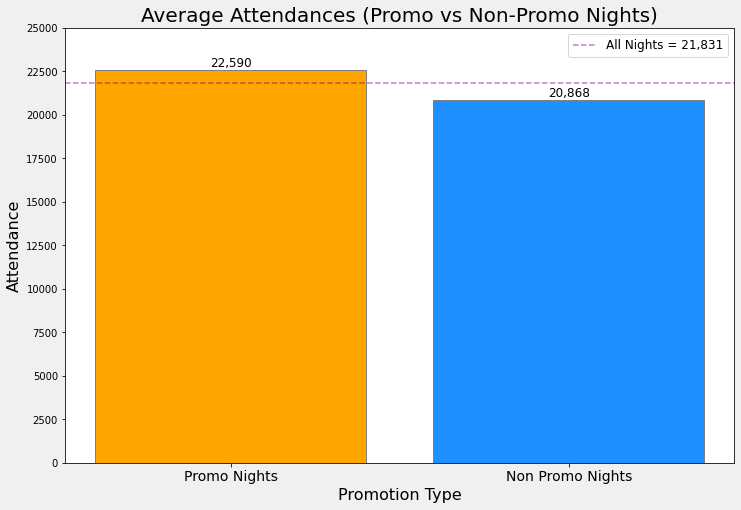

In [95]:
# Define prom vs non promo night data
labels = ["All Nights", "Promo Nights", "Non Promo Nights"]
values = [round(df['Attendance'].mean()), round(df_yespromo['Attendance'].mean()), round(df_nopromo['Attendance'].mean())]

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,8))
ax.axhline(y=values[0], color='purple', linestyle='--', label=f"All Nights = {'{:,.0f}'.format(round(df['Attendance'].mean()))}", alpha=.5)
bars = ax.bar(labels[1:], values[1:], color=['orange', 'dodgerblue'], edgecolor='gray')

# Set light grey background color
fig.patch.set_facecolor('#F0F0F0')

# Set y-axis ticks
plt.yticks(range(0, int(max(values))+2500, 2500))

# Add title and axis labels
plt.title("Average Attendances (Promo vs Non-Promo Nights)", fontsize=20)
plt.xlabel("Promotion Type", fontsize=16)
plt.ylabel("Attendance", fontsize=16)

# Add legend
ax.legend(fontsize=12)

plt.xticks(fontsize=14)

# Add value labels to bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, locale.format_string('%d', round(height), grouping=True), ha='center', va='bottom', fontsize=12)

# Display the chart
plt.show()

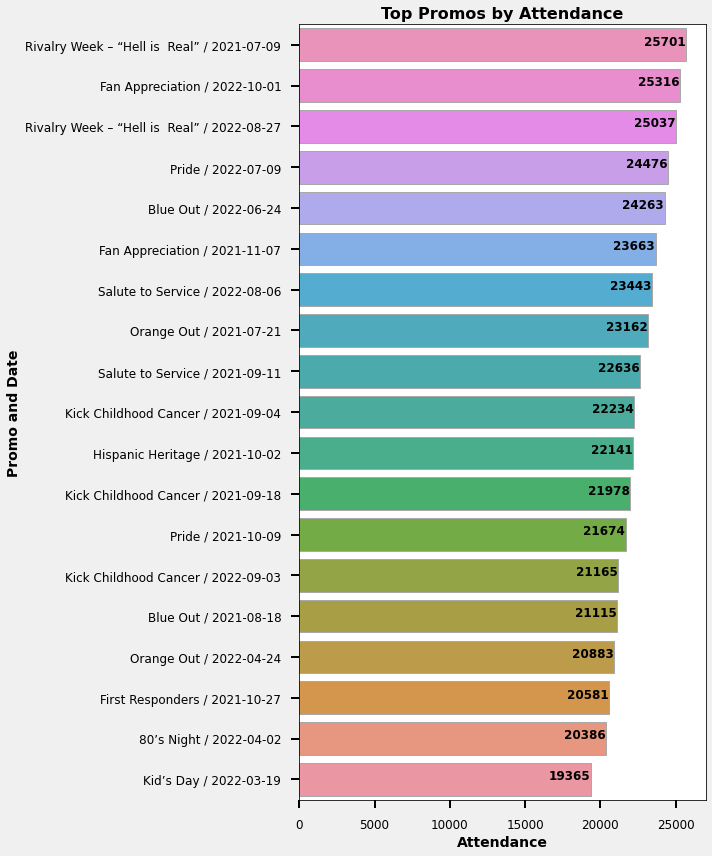

In [96]:
# Display horizontal bar chart ranking promos by attendance

# Sort DataFrame by 'Attendance' column in descending order
df_promo_sorted = df_yespromo.sort_values(by='Attendance', ascending=True)

# Concatenate 'Promo' and 'Date' columns
df_promo_sorted['PromoDate'] = df_promo_sorted['Promo'] + ' / ' + df_promo_sorted['Date'].astype(str)

# Create horizontal bar chart using Seaborn
fig, ax = plt.subplots(figsize=(10, 12))
fig.patch.set_facecolor('#F0F0F0')
sns.barplot(x=df_promo_sorted['Attendance'], y=df_promo_sorted['PromoDate'], edgecolor='darkgray')
ax.set_xlabel('Attendance', fontsize=14, fontweight='bold')
ax.set_ylabel('Promo and Date', fontsize=14, fontweight='bold')
ax.set_title('Top Promos by Attendance', fontsize=16, fontweight='bold')
ax.set_ylim(-0.5, len(df_promo_sorted)-0.5)
ax.tick_params(axis='x', labelsize=12, width=2, length=8, labelcolor='black', pad=10)
ax.tick_params(axis='y', labelsize=12, width=2, length=8, labelcolor='black', pad=10)
for i, v in enumerate(df_promo_sorted['Attendance']):
    ax.text(v-2800, i, str(round(v)), color='black', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [97]:
# Determine Statistical Significance

# Extract the Attendance data for each group
attendance_yespromo = df_yespromo["Attendance"]
attendance_nopromo = df_nopromo["Attendance"]

# Perform a two-sample welch t-test to determine if the means of the two groups are statistically different
t_stat, p_value = stats.ttest_ind(attendance_yespromo, attendance_nopromo, equal_var=False)

# Print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

t-statistic:  1.1927410127242395
p-value:  0.24977720011569846


### 3. Determine whether weekend vs weekday has a statistically significant impact on  attendance. 

In [98]:
df_week = df[~df['Day'].isin(['Sat', 'Sun'])]
df_weekend = df[df['Day'].isin(['Sat', 'Sun'])]

In [99]:
df_week

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
3,2021-07-09,19:30,Fri,Home,Columbus Crew,D,25701.0,2,2,0.9,1.0,50,4-2-3-1,3-5-3,0.375,Rivalry Week – “Hell is Real”
4,2021-07-21,20:00,Wed,Home,Atlanta Utd,D,23162.0,1,1,1.0,1.9,45,4-3-3,3-6-4,0.333,Orange Out
7,2021-08-18,19:30,Wed,Home,CF Montréal,D,21115.0,0,0,0.9,0.4,46,4-4-1-1,3-7-8,0.300,Blue Out
14,2021-10-20,19:30,Wed,Home,Chicago Fire,L,21369.0,3,4,2.6,2.3,41,5-3-2,4-18-8,0.182,
15,2021-10-27,19:30,Wed,Home,Nashville,L,20581.0,3,6,2.4,1.8,47,4-4-2,4-20-8,0.167,First Responders
21,2022-05-04,19:30,Wed,Home,Toronto FC,W,19563.0,2,0,4.4,0.5,60,4-2-3-1,4-5-1,0.444,
23,2022-06-24,19:30,Fri,Home,Orlando City,W,24263.0,1,0,1.2,0.3,46,3-4-1-2,7-7-2,0.500,Blue Out
24,2022-06-29,19:30,Wed,Home,NYCFC,D,21258.0,4,4,2.2,2.7,45,3-4-1-2,7-7-3,0.500,
26,2022-07-13,20:00,Wed,Home,Vancouver,D,21078.0,2,2,1.7,1.6,61,3-4-1-2,7-7-6,0.500,


In [100]:
df_weekend

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2021-05-16,16:00,Sun,Home,Inter Miami,L,6000.0,2,3,1.2,1.9,52,4-4-1-1,0-3-1,0.000,
1,2021-05-29,15:00,Sat,Home,New England,L,11000.0,0,1,0.8,1.9,44,5-3-2,1-4-1,0.200,
2,2021-06-19,19:30,Sat,Home,Colorado Rapids,L,25054.0,0,2,2.2,0.8,54,4-3-3,1-5-1,0.167,
5,2021-07-31,19:30,Sat,Home,D.C. United,D,25060.0,0,0,1.7,0.5,68,4-2-3-1,3-7-5,0.300,
6,2021-08-07,19:30,Sat,Home,Orlando City,D,24113.0,1,1,1.2,1.2,47,4-2-3-1,3-7-7,0.300,
8,2021-09-04,20:00,Sat,Home,Inter Miami,L,22234.0,0,1,0.7,1.1,49,3-5-2,3-10-8,0.231,Kick Childhood Cancer
9,2021-09-11,20:00,Sat,Home,Toronto FC,W,22636.0,2,0,1.4,0.7,50,4-2-3-1,4-10-8,0.286,Salute to Service
10,2021-09-18,19:30,Sat,Home,NYCFC,L,21978.0,1,2,0.9,1.4,44,4-2-3-1,4-12-8,0.250,Kick Childhood Cancer
11,2021-10-02,19:30,Sat,Home,NY Red Bulls,L,22141.0,0,1,0.5,1.3,58,4-2-3-1,4-15-8,0.211,Hispanic Heritage
12,2021-10-09,20:00,Sat,Home,Philadelphia,L,21674.0,1,2,1.7,1.3,62,4-2-3-1,4-16-8,0.200,Pride


In [101]:
print("{:>20}: ".format("Average Attendances"))
print("{:>20}: {:>10}".format("All Nights", round(df['Attendance'].mean())))
print("{:>20}: {:>10}".format("Weekends", round(df_weekend['Attendance'].mean())))
print("{:>20}: {:>10}".format("Weekdays", round(df_week['Attendance'].mean())))

 Average Attendances: 
          All Nights:      21831
            Weekends:      21766
            Weekdays:      22010


In [102]:
# ToDo: Each day of week

In [103]:
# Determine Statistical Significance

# Extract the Attendance data for each group
attendance_week = df_week["Attendance"]
attendance_weekend = df_weekend["Attendance"]

# Perform a two-sample welch t-test to determine if the means of the two groups are statistically different
t_stat, p_value = stats.ttest_ind(attendance_week, attendance_weekend, equal_var=False)

# Print the results
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

t-statistic:  0.22412191099808051
p-value:  0.8241790149980344


### 4. Determine if team performance (FCC & Opponent) has a statistically significant impact on attendance. 

In [104]:
# Win Percentage vs Attendance
df['Date'] = pd.to_datetime(df['Date'])
df21_home = df[(df.Date.dt.year == 2021)].reset_index(drop=True)
df22_home = df[(df.Date.dt.year == 2022)].reset_index(drop=True)

In [105]:
df21_home

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2021-05-16,16:00,Sun,Home,Inter Miami,L,6000.0,2,3,1.2,1.9,52,4-4-1-1,0-3-1,0.000,
1,2021-05-29,15:00,Sat,Home,New England,L,11000.0,0,1,0.8,1.9,44,5-3-2,1-4-1,0.200,
2,2021-06-19,19:30,Sat,Home,Colorado Rapids,L,25054.0,0,2,2.2,0.8,54,4-3-3,1-5-1,0.167,
3,2021-07-09,19:30,Fri,Home,Columbus Crew,D,25701.0,2,2,0.9,1.0,50,4-2-3-1,3-5-3,0.375,Rivalry Week – “Hell is Real”
4,2021-07-21,20:00,Wed,Home,Atlanta Utd,D,23162.0,1,1,1.0,1.9,45,4-3-3,3-6-4,0.333,Orange Out
5,2021-07-31,19:30,Sat,Home,D.C. United,D,25060.0,0,0,1.7,0.5,68,4-2-3-1,3-7-5,0.300,
6,2021-08-07,19:30,Sat,Home,Orlando City,D,24113.0,1,1,1.2,1.2,47,4-2-3-1,3-7-7,0.300,
7,2021-08-18,19:30,Wed,Home,CF Montréal,D,21115.0,0,0,0.9,0.4,46,4-4-1-1,3-7-8,0.300,Blue Out
8,2021-09-04,20:00,Sat,Home,Inter Miami,L,22234.0,0,1,0.7,1.1,49,3-5-2,3-10-8,0.231,Kick Childhood Cancer
9,2021-09-11,20:00,Sat,Home,Toronto FC,W,22636.0,2,0,1.4,0.7,50,4-2-3-1,4-10-8,0.286,Salute to Service


In [106]:
df22_home 

,Date,Time,Day,Venue,Opponent,Result,Attendance,GF,GA,xG,xGA,Poss,Formation,Record,Win%,Promo
0,2022-03-05,18:00,Sat,Home,D.C. United,L,22183.0,0,1,2.4,1.7,49,3-4-1-2,0-2-0,0.000,
1,2022-03-19,13:00,Sat,Home,Inter Miami,W,19365.0,3,1,2.5,1.4,49,3-4-1-2,2-2-0,0.500,Kid’s Day
2,2022-04-02,16:00,Sat,Home,CF Montréal,L,20386.0,3,4,2.6,1.7,42,3-4-1-2,2-4-0,0.333,80’s Night
3,2022-04-24,17:00,Sun,Home,Los Angeles FC,L,20883.0,1,2,1.5,1.8,45,3-4-1-2,2-5-1,0.286,Orange Out
4,2022-05-04,19:30,Wed,Home,Toronto FC,W,19563.0,2,0,4.4,0.5,60,4-2-3-1,4-5-1,0.444,
5,2022-05-21,18:00,Sat,Home,New England,L,22844.0,2,3,0.9,0.8,52,4-2-3-1,6-6-1,0.500,
6,2022-06-24,19:30,Fri,Home,Orlando City,W,24263.0,1,0,1.2,0.3,46,3-4-1-2,7-7-2,0.500,Blue Out
7,2022-06-29,19:30,Wed,Home,NYCFC,D,21258.0,4,4,2.2,2.7,45,3-4-1-2,7-7-3,0.500,
8,2022-07-09,19:30,Sat,Home,NY Red Bulls,D,24476.0,1,1,1.5,1.2,45,3-4-1-2,7-7-5,0.500,Pride
9,2022-07-13,20:00,Wed,Home,Vancouver,D,21078.0,2,2,1.7,1.6,61,3-4-1-2,7-7-6,0.500,


In [129]:
def stat_reg_analysis(df, statx, staty, cbar_rev=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    df_new = df.copy()
    
    x=pd.to_numeric(df_new[statx]).fillna(0)
    y=pd.to_numeric(df_new[staty]).fillna(0)
    initial_cmap = plt.colormaps.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)
    

    if cbar_rev:
        plt.scatter(x,y, c=y, cmap=reversed_cmap, s=60, edgecolor='black')
    else:
        plt.scatter(x,y, c=y, cmap=initial_cmap, s=60, edgecolor='black')

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(x.mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(y.mean(),2)}", linestyle='dashed', color='cyan', linewidth=2)
    
    xmin = x.min()-(x.max()*.1)
    ymin = y.min()-(y.max()*.1)
    
    xmax = x.max()+(x.max()*.1)
    ymax = y.max()+(y.max()*.1)

    plt.xlabel(statx, fontsize=22, fontweight='bold')
    plt.ylabel(staty, fontsize=22, fontweight='bold')
    
    plt.legend(loc='best', prop={'weight':'bold', 'size':14})

    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    plt.title(f'{statx} vs {staty} ~ NFL 2022', fontsize=24, fontweight='bold')
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.clim(ymin,ymax)
    
    cbar = plt.colorbar(cmap='RdYlGn')

    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(loc='best')
    
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

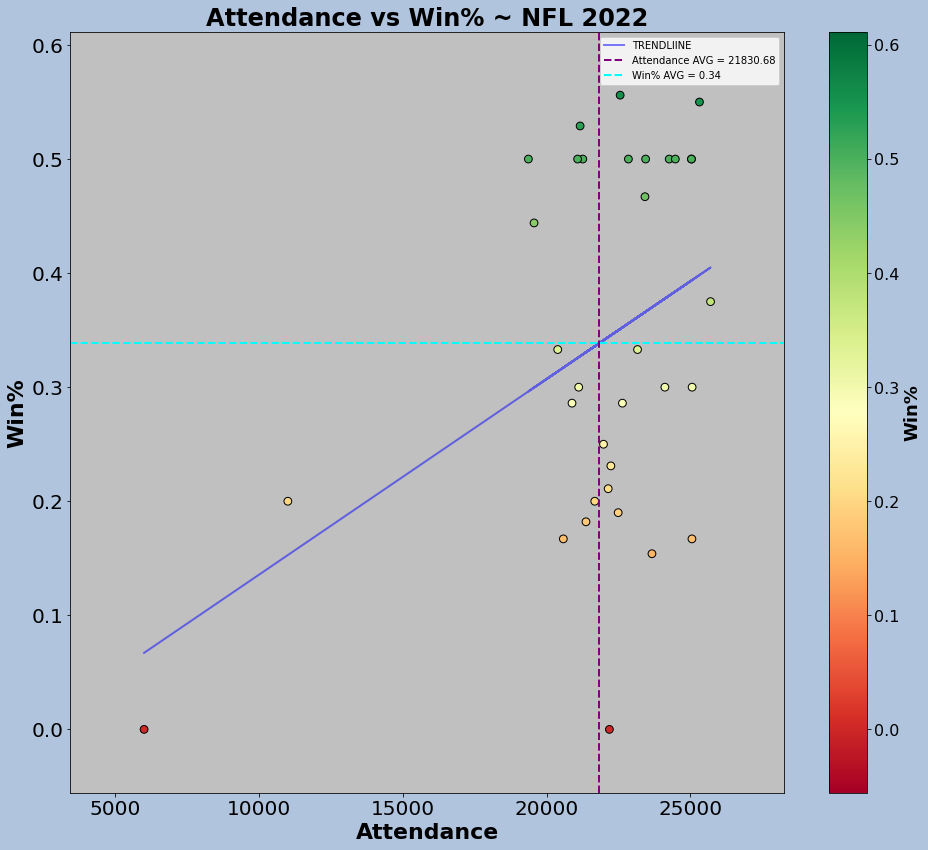


Season Trend Line Equation: y = 0.000017x + (-0.035798)

R-squared: 0.16909324075788212


In [130]:
stat_reg_analysis(df, 'Attendance', 'Win%', cbar_rev=False)

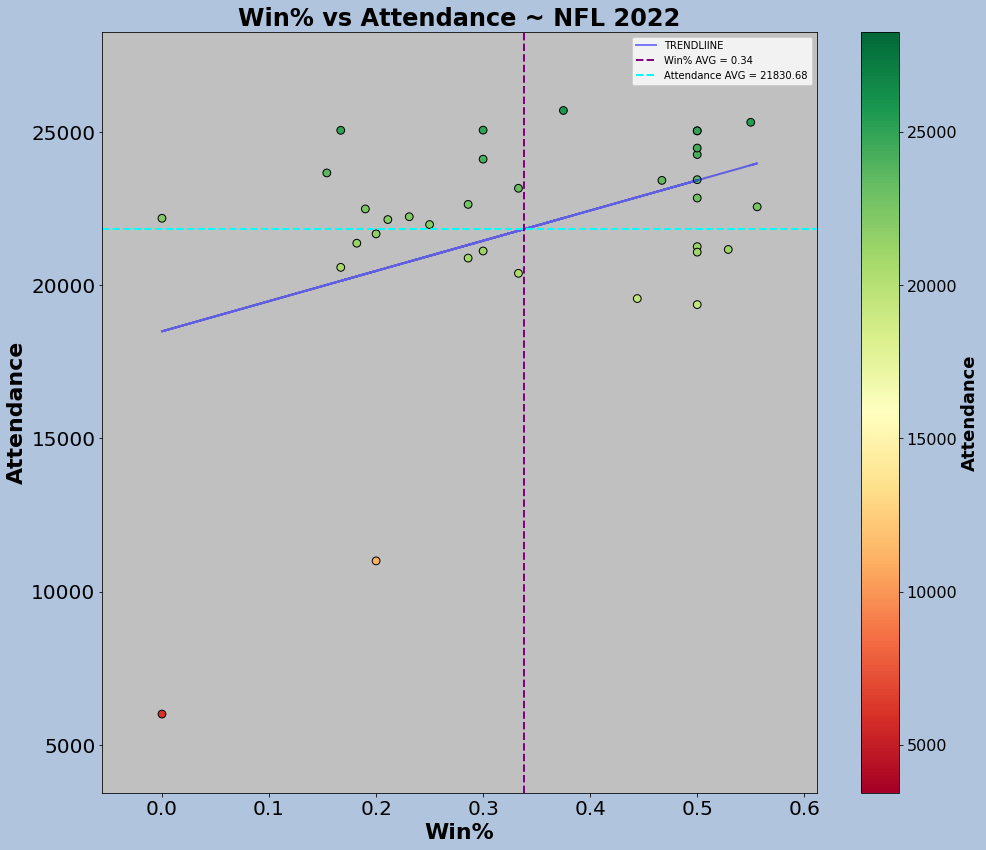


Season Trend Line Equation: y = 9860.688829x + (18492.253261)

R-squared: 0.16909324075788223


In [131]:
stat_reg_analysis(df, 'Win%', 'Attendance', cbar_rev=False)

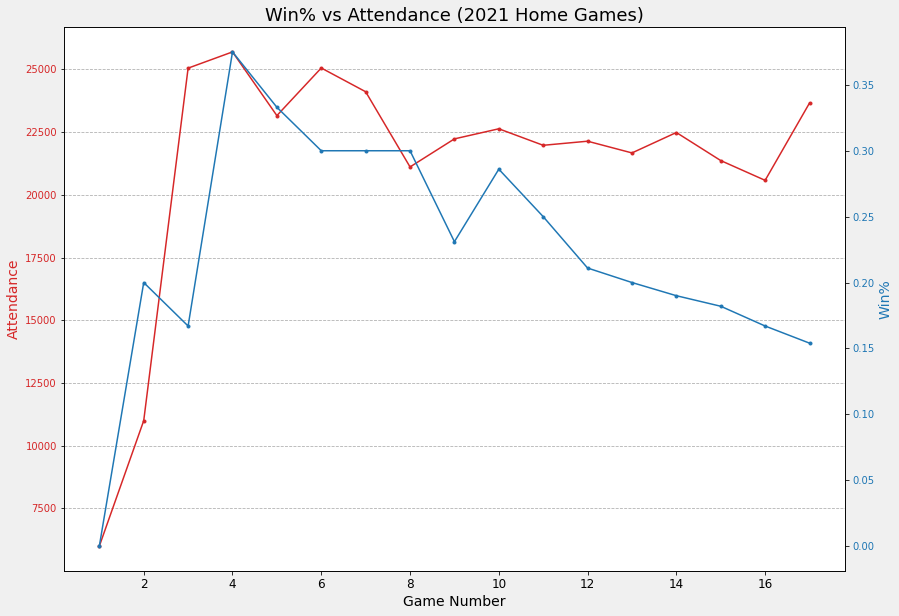

In [132]:
fig, ax1 = plt.subplots(figsize=(14, 10))

# Set light grey background color
fig.patch.set_facecolor('#F0F0F0')

# Plot the attendance on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Game Number', fontsize=14)
ax1.set_ylabel('Attendance', color=color, fontsize=14)
ax1.plot(df21_home.index+1, df21_home['Attendance'], color=color, marker='.')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(axis='y', linestyle='--')

# Create a second y-axis with Win% and plot it
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Win%', color=color, fontsize=14)
ax2.plot(df21_home.index+1, df21_home['Win%'], color=color, marker='.')
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelsize=12)

plt.title('Win% vs Attendance (2021 Home Games)', fontsize=18)
plt.show()

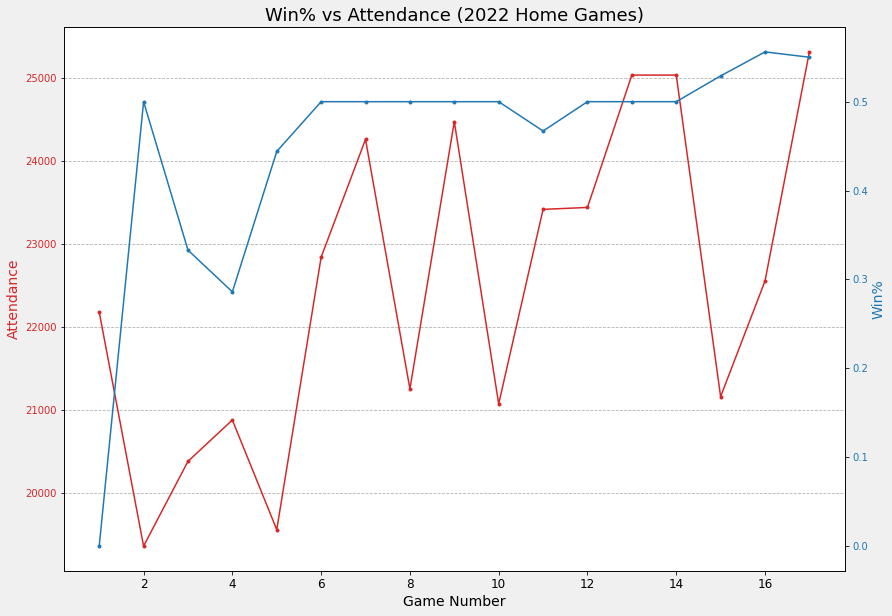

In [133]:
fig, ax1 = plt.subplots(figsize=(14, 10))

# Set light grey background color
fig.patch.set_facecolor('#F0F0F0')

# Plot the attendance on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Game Number', fontsize=14)
ax1.set_ylabel('Attendance', color=color, fontsize=14)
ax1.plot(df22_home.index+1, df22_home['Attendance'], color=color, marker='.')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelsize=12)
ax1.grid(axis='y', linestyle='--')

# Create a second y-axis with Win% and plot it
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Win%', color=color, fontsize=14)
ax2.plot(df22_home.index+1, df22_home['Win%'], color=color, marker='.')
ax2.tick_params(axis='y', labelcolor=color)
ax2.tick_params(axis='x', labelsize=12)

plt.title('Win% vs Attendance (2022 Home Games)', fontsize=18)
plt.show()

### 5. Construct a match-by-match attendance forecast model for the 2023 season. 

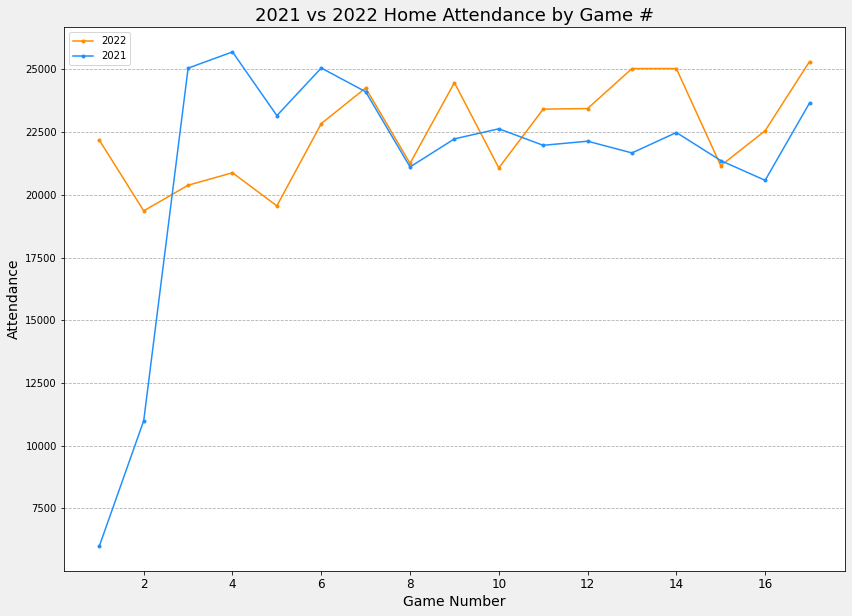

In [134]:
fig, ax1 = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#F0F0F0')
ax1.set_xlabel('Game Number', fontsize=14)
ax1.set_ylabel('Attendance',  fontsize=14)
ax1.plot(df22_home.index+1, df22_home['Attendance'], color="darkorange", marker='.', label="2022")
ax1.plot(df21_home.index+1, df21_home['Attendance'], color="dodgerblue", marker='.', label="2021")
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', labelsize=12)
plt.legend()
plt.title('2021 vs 2022 Home Attendance by Game #', fontsize=18)
ax1.grid(axis='y', linestyle='--')

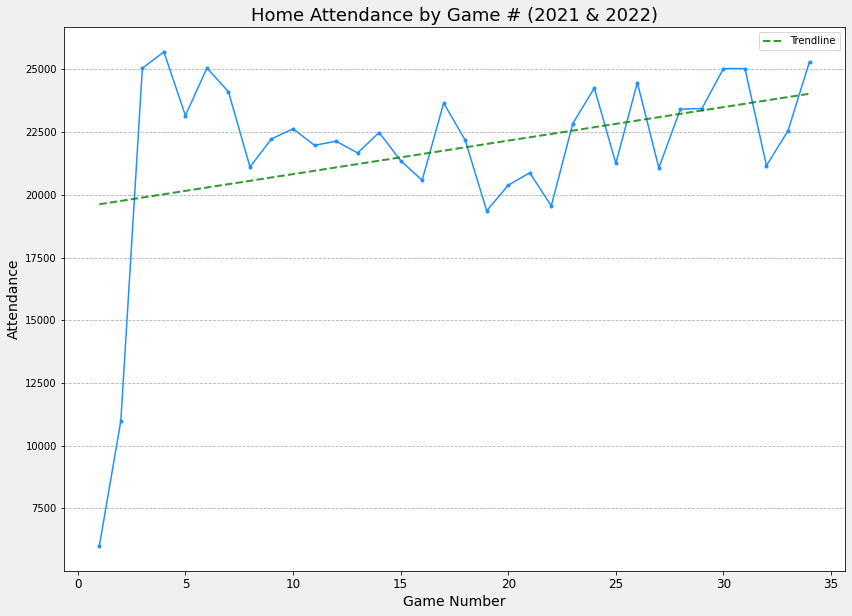

In [135]:
# Calculate linear regression line
x = df.index + 1
y = df['Attendance']
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

# Plot scatter plot and trendline
fig, ax1 = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#F0F0F0')
ax1.set_xlabel('Game Number', fontsize=14)
ax1.set_ylabel('Attendance',  fontsize=14)
ax1.plot(x, y, color="dodgerblue", marker='.')
ax1.plot(x, trendline, color="green", linewidth=2, label="Trendline",linestyle="--", alpha=0.8)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', labelsize=12)
plt.legend()
plt.title('Home Attendance by Game # (2021 & 2022)', fontsize=18)
ax1.grid(axis='y', linestyle='--')
plt.show()

In [136]:
equation = f"y = {slope:.2f}x + {intercept:.2f}"
print(equation)

y = 133.54x + 19493.73


In [137]:
# For 2023 
print("2023 Estimates")
print(f"Min: {slope*35 + intercept:.0f}")
print(f"Max: {slope*52 + intercept:.0f}")

2023 Estimates
Min: 24168
Max: 26438


### 6. What other data, variables, or means of analysis would you consider for looking at this problem further?

In [138]:
def r2_comparison_from_y(df, staty):
    
    pd.set_option('display.max_rows', None)
    
    df_new = df.copy()
    
    try: df_new = df_new.drop(columns=['TEAM_NAME'])
    except: pass
    try: df_new = df_new.drop(columns=['TEAM_ABBR'])
    except: pass
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    y=df_new[staty]
    y=y.fillna(y.mean())
    
    for i in df_new.columns:
        x=df_new[i]
        try: x=x.fillna(x.mean())
        except: x=x.fillna(0)
        if is_numeric_dtype(df_new[i]):
            model = LinearRegression()
            model = model.fit(x.values.reshape(-1, 1), y)
            r2= model.score(x.values.reshape(-1, 1), y)
            df_temp = pd.DataFrame([[i, staty, r2]], columns=['x','y','r2'])
            df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparison_from_y(df, 'Attendance')

,x,y,r2
0,Attendance,Attendance,1.000000e+00
1,Win%,Attendance,1.690932e-01
2,xGA,Attendance,1.130431e-01
3,GA,Attendance,2.159707e-02
4,GF,Attendance,1.518185e-03
5,Poss,Attendance,7.386338e-06
6,xG,Attendance,4.739573e-08
